/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


Epoch 1/5, Loss: 0.0995
Epoch 2/5, Loss: 0.0390
Epoch 3/5, Loss: 0.0173
Epoch 4/5, Loss: 0.0172
Epoch 5/5, Loss: 0.0097

Validation Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



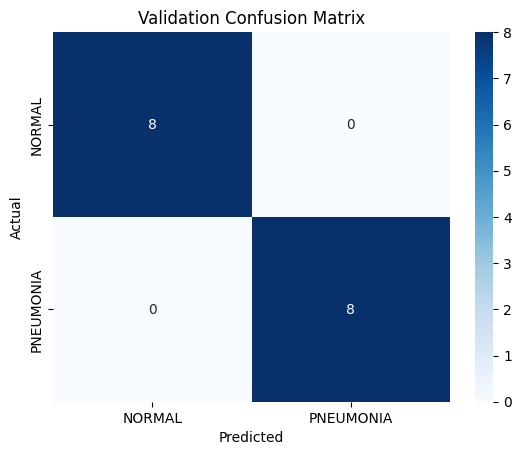


Test Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.49      0.66       234
   PNEUMONIA       0.77      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.74      0.76       624
weighted avg       0.85      0.81      0.79       624



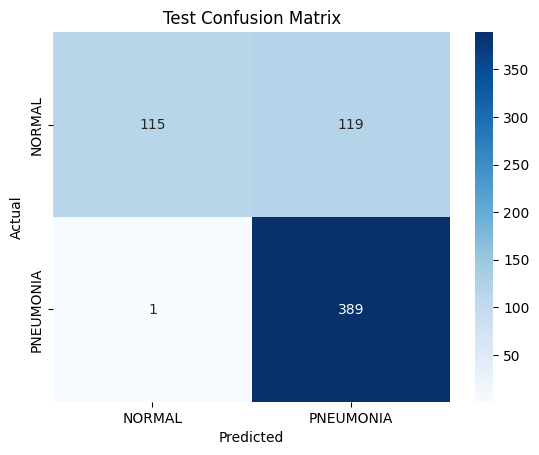

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Config
BATCH_SIZE = 16
EPOCHS = 5
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset paths (Kaggle input folder)
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Model: Transfer Learning with ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model = model.to(DEVICE)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
def train():
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
def evaluate(loader, label="Test"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(f"\n{label} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_data.classes))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_data.classes,
                yticklabels=train_data.classes)
    plt.title(f'{label} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Run training and evaluation
train()
evaluate(val_loader, label="Validation")
evaluate(test_loader, label="Test")
